## Download Data

In [1]:
import numpy as np
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table
import dipy.reconst.dti as dti
from dipy.data import get_fnames

hardi_fname, hardi_bval_fname, hardi_bvec_fname = get_fnames('stanford_hardi')
data, affine, voxsize = load_nifti(hardi_fname, return_voxsize=True)

bvals, bvecs = read_bvals_bvecs(hardi_bval_fname, hardi_bvec_fname)
gtab = gradient_table(bvals, bvecs)

print('data.shape (%d, %d, %d, %d)' % data.shape)

data.shape (81, 106, 76, 160)


In [2]:
from dipy.segment.mask import median_otsu

maskdata, mask = median_otsu(data, vol_idx=range(10, 50), median_radius=3,
                             numpass=1, autocrop=True, dilate=2)
print('maskdata.shape (%d, %d, %d, %d)' % maskdata.shape)

maskdata.shape (71, 88, 62, 160)


## Fit DTI Model

In [3]:
tenmodel = dti.TensorModel(gtab)
tenfit = tenmodel.fit(maskdata[:, :, 28:29])
# tenfit = tenmodel.fit(data[:, :, 28:29])

## Example of Eigenvalue and Eigenvector

### Eigenvalues of first voxel

In [4]:
tenfit.evals[0,0,0]

array([5.00006825e-10, 5.00006825e-10, 5.00006825e-10])

### Eigenvectors of first voxel

In [5]:
tenfit.evecs[0,0,0]

array([[ 0.20704389,  0.91037302, -0.35826496],
       [ 0.00976605,  0.36425845,  0.9312467 ],
       [-0.97828291,  0.19630777, -0.06652674]])

In [6]:
from dipy.reconst.dti import fractional_anisotropy, color_fa

FA = fractional_anisotropy(tenfit.evals)
FA[np.isnan(FA)] = 0

FA = np.clip(FA, 0, 1)
RGB = color_fa(FA, tenfit.evecs)

## Visualisation by Ellipsoids

In [7]:
from IPython.display import Image
from dipy.data import get_sphere
sphere = get_sphere('repulsion724')

from dipy.viz import window, actor

# Enables/disables interactive visualization
interactive = False

scene = window.Scene()

# evals = tenfit.evals[13:43, 44:74, 28:29]
# evecs = tenfit.evecs[13:43, 44:74, 28:29]
evals = tenfit.evals
evecs = tenfit.evecs

In [8]:
cfa = RGB
cfa /= cfa.max()

scene.add(actor.tensor_slicer(evals, evecs, scalar_colors=cfa, sphere=sphere,
                              scale=0.3))

window.record(scene, n_frames=1, out_path='tensor_ellipsoids.png',
              size=(600, 600))
if interactive:
    window.show(scene)

In [9]:
scene.clear()

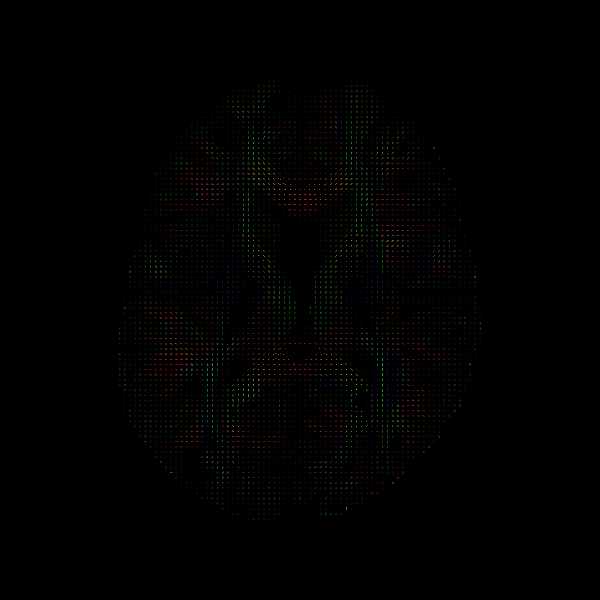

In [10]:
Image('tensor_ellipsoids.png')

## Visualisation by ODFs

In [11]:
tensor_odfs = tenfit.odf(sphere)

odf_actor = actor.odf_slicer(tensor_odfs, sphere=sphere, scale=0.5,
                             colormap=None)
scene.add(odf_actor)
window.record(scene, n_frames=1, out_path='tensor_odfs.png', size=(600, 600))
if interactive:
    window.show(scene)

In [12]:
scene.clear()

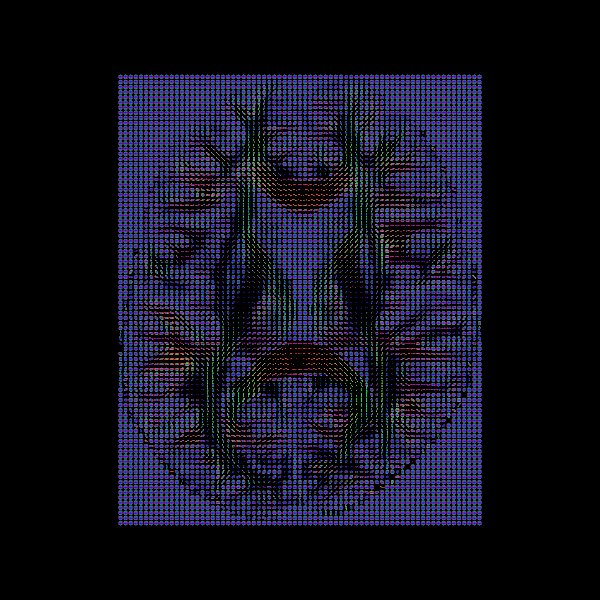

In [13]:
Image('tensor_odfs.png')

## Reslice Data to Lower Resolution

In [14]:
from dipy.align.reslice import reslice

In [15]:
data_lr, affine_lr = reslice(data, affine, voxsize, [i*2 for i in voxsize])
data_lr.shape

(40, 53, 38, 160)

In [16]:
# new_shape = tuple([i//2 for i in data[:-1].shape[:-1]]) + (2,2,2) + (data.shape[-1],)
# new_strides = tuple(data.strides[:-1] * np.array([2, 2, 2])) + data.strides
# data_lr = np.mean(
#     np.lib.stride_tricks.as_strided(data[:-1], shape=new_shape, strides=new_strides), 
#     axis=(3, 4, 5)
# )
# data_lr.shape

In [17]:
maskdata, mask = median_otsu(data_lr, vol_idx=range(10, 50), median_radius=3,
                             numpass=1, autocrop=True, dilate=2)
print('maskdata.shape (%d, %d, %d, %d)' % maskdata.shape)

maskdata.shape (37, 45, 31, 160)


In [18]:
tenmodel = dti.TensorModel(gtab)
tenfit = tenmodel.fit(maskdata[:, :, 14:15])
# tenfit = tenmodel.fit(data_lr[:, :, 14:15])

FA = fractional_anisotropy(tenfit.evals)
FA[np.isnan(FA)] = 0

FA = np.clip(FA, 0, 1)
RGB = color_fa(FA, tenfit.evecs)

In [19]:
evals = tenfit.evals
evecs = tenfit.evecs

cfa = RGB
cfa /= cfa.max()

scene.add(actor.tensor_slicer(evals, evecs, scalar_colors=cfa, sphere=sphere,
                              scale=0.3))

window.record(scene, n_frames=1, out_path='tensor_ellipsoids_lr.png',
              size=(600, 600))
if interactive:
    window.show(scene)

In [20]:
scene.clear()

tensor_odfs = tenfit.odf(sphere)

odf_actor = actor.odf_slicer(tensor_odfs, sphere=sphere, scale=0.5,
                             colormap=None)
scene.add(odf_actor)
window.record(scene, n_frames=1, out_path='tensor_odfs_lr.png', size=(600, 600))
if interactive:
    window.show(scene)

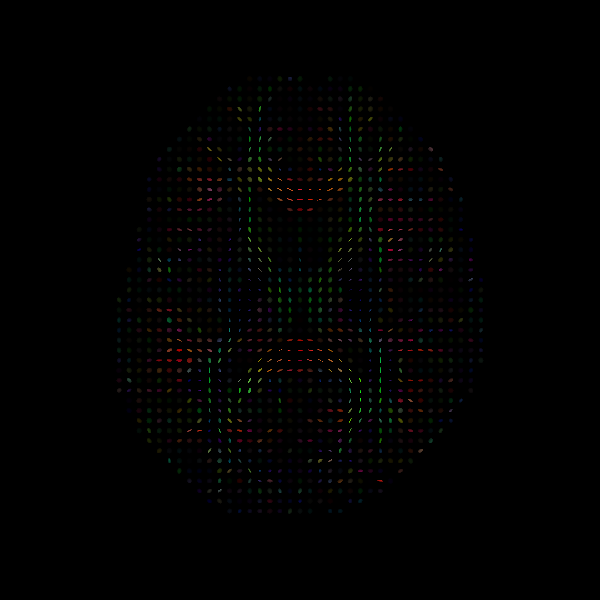

In [21]:
Image('tensor_ellipsoids_lr.png')

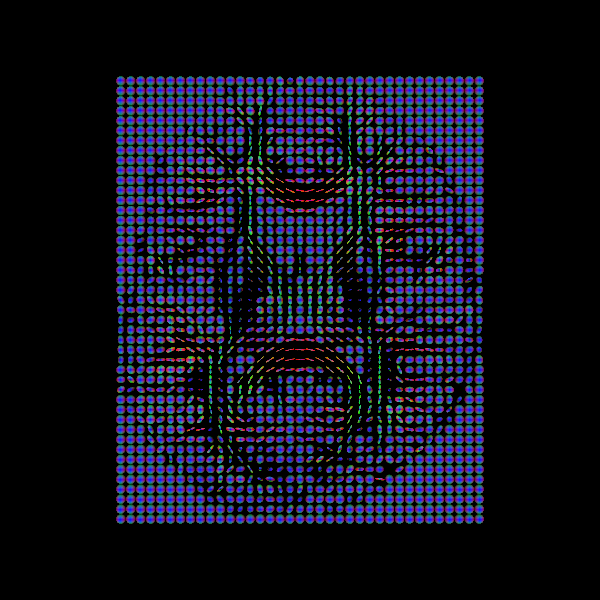

In [22]:
Image('tensor_odfs_lr.png')